# Gaia case study

# A) Data Modelling Approach

## Overview of the Data Modelling Approach:

To support the diverse needs of Gaia's teams, we will design a **dimensional data model** optimized for analytics and reporting. This will include:

1. **Star Schema Design**: Separate data into:
   - **Fact tables**: Quantitative data for analysis (e.g., costs, rounds, treatment outcomes).
   - **Dimension tables**: Contextual information to slice and dice fact data (e.g., member details, clinic data).

2. **Granularity**: Ensure the fact tables are at the right level of detail to answer the questions posed by Nikki, Victor, and Adrien. For instance:
   - Clinic invoices: Detail each invoice item (e.g., medication, procedure, etc.).
   - Treatment journey: Include each treatment event and round outcome.

3. **Key Features**:
   - Maintain referential integrity between dimensions and facts using surrogate keys.
   - Include timestamps for event tracking to support time-series analysis.
   - Use status and flag indicators for Adrien’s operational monitoring needs.

4. **Slowly Changing Dimensions (SCDs)**:
   - Use SCD Type 2 for dimensions like `Dim_Members` and `Dim_Clinics` to track historical changes in attributes such as membership type, clinic costs, and specialties.
   - Include effective date ranges (`Effective_Start_Date`, `Effective_End_Date`) and a `Current_Flag` column to manage historical and current records.

5. **Data Quality and Validation**:
   - Implement a staging layer to clean and validate raw data before transformation.
   - Apply validation rules to catch anomalies such as missing values, duplicates, and outliers.
   - Use tools like dbt for automated data quality checks.

6. **Time-Series Analysis**:
   - Include a dedicated `Dim_Date` table to standardize date attributes for analysis.
   - Design fact tables to support time-based trends, such as IVF cycle durations and cost analysis.

7. **Hierarchical Relationships**:
   - Build hierarchical dimensions like `Dim_Location` (Country → Region → City) and `Dim_Clinic_Group` (Parent Organization → Clinic) to enable multi-level analysis. This might be useful for geography specific regulations or other constraints useful to take into account.

8. **Handling Many-to-Many Relationships**:
   - Use bridge tables (e.g., `Bridge_Member_Clinics`) to manage relationships where members interact with multiple clinics.

9. **Metadata and Auditability**:
   - Add metadata tables like `Meta_Process_Log` (ETL job tracking) and `Meta_Table_Schema` (describing table structures) for transparency and auditability.

10. **Aggregates and Pre-Computation**:
    - Create pre-aggregated tables or materialized views for high-level metrics like monthly costs or success rates.

11. **Scalability and Future Growth**:
    - Design a modular schema with surrogate keys to easily incorporate new dimensions and facts.
    - Optimize for columnar storage in cloud warehouses (e.g., Snowflake, BigQuery).

---

## Steps to Build the Model

### 1. Requirements Gathering
   - Conduct detailed interviews with Nikki, Victor, and Adrien to validate the KPIs, metrics, and fields they require.
   - Identify critical joins, filters, and aggregations.

### 2. Source Analysis
   - Map raw data fields from the data warehouse to the target model.
   - Clean and normalize data where necessary (e.g., standardize clinic names, member IDs).

### 3. Design the Data Model
   - Create ER diagrams for clarity.
   - Use a **modular approach** to allow extensions as needs grow.

### 4. Build and Validate
   - Use ETL/ELT tools like dbt or SQL to transform raw data into the target model.
   - Validate the model with test queries and dashboards for each team's use case.

---

## Example High-Level Model

### Fact Tables

#### 1. `Fact_Treatment_Costs`
- Tracks all costs (clinic invoices, medications, fixed liabilities).
- **Granularity**: One row per invoice item.

**Columns**:
- `Member_ID` (FK)
- `Clinic_ID` (FK)
- `Invoice_ID`
- `Item_Type` (e.g., medication, procedure)
- `Cost`
- `Date`

#### 2. `Fact_Treatment_Journey`
- Tracks IVF rounds and cycles, including outcomes.
- **Granularity**: One row per treatment event or cycle.

**Columns**:
- `Member_ID` (FK)
- `Round_ID`
- `Cycle_ID`
- `Embryos_Created`
- `Outcome_Status` (e.g., live birth, frozen embryos)
- `Event_Type` (e.g., stimulation, retrieval, transfer)
- `Event_Date`

#### 3. `Fact_Membership_Status`
- Tracks policy utilization and status.
- **Granularity**: One row per membership per day (or policy change).

**Columns**:
- `Member_ID` (FK)
- `Policy_Start_Date`
- `Policy_End_Date`
- `Cycles_Remaining`
- `Active_Flag`
- `Last_Updated`

---

### Dimension Tables

#### 1. `Dim_Members` (SCD Type 2)
- Tracks member attributes with historical changes.

**Columns**:
- `Member_ID` (PK)
- `Name`
- `DOB`
- `Location`
- `Membership_Type`
- `Effective_Start_Date`
- `Effective_End_Date`
- `Is_Current_Flag`

#### 2. `Dim_Clinics` (SCD Type 2)
- Tracks clinic attributes with historical changes.

**Columns**:
- `Clinic_ID` (PK)
- `Clinic_Name`
- `Location`
- `Average_Cost_Per_Cycle`
- `Specialty`
- `Effective_Start_Date`
- `Effective_End_Date`
- `Is_Current_Flag`

#### 3. `Dim_Treatment_Rounds`
- Contextual data about each IVF round.

**Columns**:
- `Round_ID` (PK)
- `Member_ID` (FK)
- `Cycle_ID` (FK)
- `Start_Date`
- `End_Date`
- `Outcome`

#### 4. `Dim_Date`
- Provides standardized time attributes for analysis.

**Columns**:
- `Date_ID` (PK)
- `Date`
- `Year`
- `Month`
- `Week`
- `Day`
- `Fiscal_Year`
- `Holiday_Flag`

---

## Sample Queries for Each Team

### **Nikki (Finance Team)**  
### Query: What are the unit economics of our product by clinic?

```sql
SELECT 
    c.Clinic_Name,
    SUM(tc.Cost) AS Total_Cost,
    SUM(CASE WHEN tc.Item_Type = 'Medication' THEN tc.Cost ELSE 0 END) AS Medication_Cost,
    SUM(CASE WHEN tc.Item_Type = 'Procedure' THEN tc.Cost ELSE 0 END) AS Procedure_Cost,
    COUNT(DISTINCT tc.Invoice_ID) AS Invoice_Count
FROM 
    Fact_Treatment_Costs tc
JOIN 
    Dim_Clinics c ON tc.Clinic_ID = c.Clinic_ID
GROUP BY 
    c.Clinic_Name;


### **Adrien (Ops Team)**  
### Query: Which members are nearing the end of their coverage or have stalled in their treatment?

```sql
SELECT 
    m.Member_ID,
    m.Name,
    ms.Cycles_Remaining,
    ms.Policy_End_Date,
    MAX(tj.Event_Date) AS Last_Treatment_Date
FROM 
    Dim_Members m
JOIN 
    Fact_Membership_Status ms ON m.Member_ID = ms.Member_ID
LEFT JOIN 
    Fact_Treatment_Journey tj ON m.Member_ID = tj.Member_ID
WHERE 
    ms.Cycles_Remaining <= 1 
    DATEDIFF(NOW(), MAX(tj.Event_Date)) > 30
GROUP BY 
    m.Member_ID, m.Name, ms.Cycles_Remaining, ms.Policy_End_Date;



### **Viktor (Insurance Team)**  
### Query: What is the average number of rounds per cycle, and their outcomes?

```sql
SELECT 
    m.Membership_Type,
    AVG(r.Round_Count) AS Avg_Rounds_Per_Cycle,
    COUNT(CASE WHEN tj.Outcome_Status = 'Live Birth' THEN 1 END) AS Successful_Rounds,
    COUNT(CASE WHEN tj.Outcome_Status = 'Frozen Embryos' THEN 1 END) AS Frozen_Embryo_Rounds
FROM 
    Dim_Members m
JOIN 
    Fact_Treatment_Journey tj ON m.Member_ID = tj.Member_ID
GROUP BY 
    m.Membership_Type;
    


---

## Tools & infrastructure

- **ETL/ELT**: dbt for transformations.
- **Data Warehouse**: Snowflake.
- **Visualization**: Omni, Tableau etc..
- **Scheduling**: Apache Airflow for automated pipeline updates.


# B) Data analysis

## 1) Reading data 

In [5]:
import pandas as pd

# Define the file paths
base_path = '/Users/mohamedmakni/Desktop/avocado/gaia'
cycles_file = f"{base_path}/All Cycles.csv"
rounds_file = f"{base_path}/All Rounds.csv"
invoices_file = f"{base_path}/All Invoices.csv"

# Load the datasets into DataFrames
cycles_df = pd.read_csv(cycles_file)
rounds_df = pd.read_csv(rounds_file)
invoices_df = pd.read_csv(invoices_file)

In [7]:
# Print the sizes of the datasets
print("Dataset Sizes:")
print(f"Cycles DataFrame: {cycles_df.shape[0]} rows, {cycles_df.shape[1]} columns")
print(f"Rounds DataFrame: {rounds_df.shape[0]} rows, {rounds_df.shape[1]} columns")
print(f"Invoices DataFrame: {invoices_df.shape[0]} rows, {invoices_df.shape[1]} columns")

Dataset Sizes:
Cycles DataFrame: 256 rows, 4 columns
Rounds DataFrame: 236 rows, 5 columns
Invoices DataFrame: 817 rows, 8 columns


In [6]:
from IPython.display import display

# Display prettier tables
display(cycles_df.head().style.set_table_attributes("style='display:inline'").set_caption("Cycles DataFrame"))
display(rounds_df.head().style.set_table_attributes("style='display:inline'").set_caption("Rounds DataFrame"))
display(invoices_df.head().style.set_table_attributes("style='display:inline'").set_caption("Invoices DataFrame"))


,Membership ID,Cycle Number,Cycle Liability Post Discount,Clinics ID
0,cltqx2w4q00010ml1fhm9hy32,1,6283.400000,7ebcc0c8d77d42309ab6dae22beb6e9a
1,clrhwsasp00080dl40mj81twz,1,7661.020000,ed236c69937b44678dcd6875393d8cc5
2,clzsmivof00010dl06wjr49bu,1,6860.330000,ce6d99f5787a45e8994569266c41d016
3,clvdlselv00010mjvcyi3d5xm,1,7704.800000,95a60992ddb147f488a369041a79ff4e
4,clxvknofo00010djrcs1r5h61,1,10238.750000,786bc177d2654e168220430f0291bfb2


,Membership ID,Cycle Number,Round Number (Excluding Cancelled Rounds And Counts Towards Insurance = True),Round Type,Round Current Status
0,clr88hn3100070cl62log9v64,1,1,FROZEN_TRANSFER,PENDING_TRANSFER
1,clrhmcyo600010cjn1739f02m,2,2,ANY_IVF_WITH_FRESH_TRANSFER,TREATMENT_STARTED
2,clrhmcyo600010cjn1739f02m,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
3,clrhwsasp00080dl40mj81twz,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
4,clrkf5m7r00010cla7eio6d0b,2,1,ANY_IVF_WITH_FRESH_TRANSFER,PREGNANCY


,INVOICE_ID,MEMBERSHIP_ID,ROUND_NUM,SUPPLIER_TYPE,GROSS_TOTAL_AMOUNT,GROSS_TREATMENT_AMOUNT,GROSS_MEDICATION_AMOUNT,GROSS_OTHER_AMOUNT
0,1yZASciiIWWCsR7MDpxCoKRY1ldGcFSk_,cm06sxge500010dl4cwc66pqa,1,CLINIC,500.000000,0.000000,0.000000,500.000000
1,cm0p1vesa00080dl22xlc8qnu,cm06sxge500010dl4cwc66pqa,1,CLINIC,523.600000,0.000000,0.000000,523.600000
2,clzwotplq000r0dlc8cro0evx,clwtc0ngg00010bmf3jc3hb7z,1,CLINIC,2645.000000,0.000000,2645.000000,0.000000
3,1Xr7Rar9Kd70ze1qFSumQDYpMbtx2FHvD_1,clu11m89e00010cl4ghgggguo,2,CLINIC,2385.000000,0.000000,0.000000,2385.000000
4,clybzap5x00090dlc9ye05cth,clu11m89e00010cl4ghgggguo,1,CLINIC,3156.760000,0.000000,3156.760000,0.000000


## 2) Exploratory data analysis 

### Cycles data

In [25]:
display(cycles_df.head().style.set_table_attributes("style='display:inline'").set_caption("Cycles DataFrame"))

,membership_id,cycle_number,cycle_liability_post_discount,clinics_id
0,cltqx2w4q00010ml1fhm9hy32,1,6283.400000,7ebcc0c8d77d42309ab6dae22beb6e9a
1,clrhwsasp00080dl40mj81twz,1,7661.020000,ed236c69937b44678dcd6875393d8cc5
2,clzsmivof00010dl06wjr49bu,1,6860.330000,ce6d99f5787a45e8994569266c41d016
3,clvdlselv00010mjvcyi3d5xm,1,7704.800000,95a60992ddb147f488a369041a79ff4e
4,clxvknofo00010djrcs1r5h61,1,10238.750000,786bc177d2654e168220430f0291bfb2


In [28]:
# Check for duplicates in cycles_df
duplicates_cycles = cycles_df.duplicated()
print(f"Number of Duplicate Rows in cycles_df: {duplicates_cycles.sum()}")

Number of Duplicate Rows in cycles_df: 0


In [18]:
# Convert column names to lowercase and replace spaces with underscores
cycles_df.columns = cycles_df.columns.str.lower().str.replace(' ', '_')

# Check for missing values
print("Missing values in Cycles DataFrame:")
print(cycles_df.isnull().sum())

# General statistics
print("\nSummary Statistics:")
print(cycles_df.describe())

# Count unique members and clinics
unique_members = cycles_df['membership_id'].nunique()
unique_clinics = cycles_df['clinics_id'].nunique()
print(f"\nUnique Memberships: {unique_members}")
print(f"Unique Clinics: {unique_clinics}")


Missing values in Cycles DataFrame:
membership_id                    0
cycle_number                     0
cycle_liability_post_discount    0
clinics_id                       0
dtype: int64

Summary Statistics:
       cycle_number  cycle_liability_post_discount
count    256.000000                     256.000000
mean       1.144531                    9790.440156
std        0.394334                    3185.342697
min        1.000000                    2770.160000
25%        1.000000                    7875.512500
50%        1.000000                    9453.590000
75%        1.000000                   11319.325000
max        3.000000                   24062.250000

Unique Memberships: 228
Unique Clinics: 82


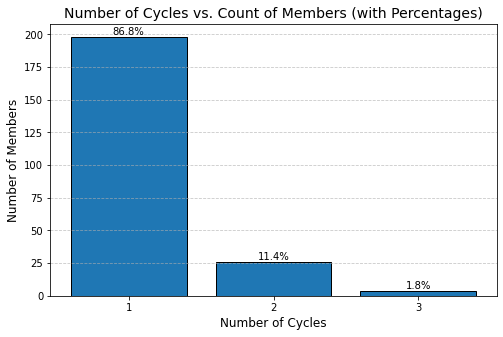

In [19]:
import matplotlib.pyplot as plt

# Aggregate data to count the number of cycles per member
cycle_counts = cycles_df.groupby('membership_id')['cycle_number'].max()
cycle_distribution = cycle_counts.value_counts().sort_index()

# Calculate percentages
total_members = cycle_distribution.sum()
percentage_distribution = (cycle_distribution / total_members) * 100

# Plot the distribution with percentages
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(cycle_distribution.index, cycle_distribution, edgecolor='black', label='Number of Members')

# Annotate bars with percentages
for bar, percentage in zip(bars, percentage_distribution):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage:.1f}%", 
            ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_title("Number of Cycles vs. Count of Members (with Percentages)", fontsize=14)
ax.set_xlabel("Number of Cycles", fontsize=12)
ax.set_ylabel("Number of Members", fontsize=12)
ax.set_xticks(cycle_distribution.index)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
# Find members who have done more than 1 cycle
multi_cycle_members = cycles_df.groupby('membership_id')['cycle_number'].max()
multi_cycle_members = multi_cycle_members[multi_cycle_members > 1].index

# Filter the original dataframe for these members
multi_cycle_data = cycles_df[cycles_df['membership_id'].isin(multi_cycle_members)]

# Find the clinics where these members had their cycles
clinics_with_multiple_cycles = multi_cycle_data['clinics_id'].unique()

# Display the result
print("Clinics where members did more than 1 cycle:")
print(clinics_with_multiple_cycles)

Clinics where members did more than 1 cycle:
['0676b700012e4676bf7a86395d32099f' 'f17b93a590674bedb6b5b6f561e2fdd4'
 'f41eb7e430e34ce183e3a5f433f9aaec' '3526634d03b540f68151fbb64833c737'
 '3bcb2e8b040a48458a981261654a5593' 'clgkl7ngy004w0jmsg1aj41sa'
 '55bfff2e54de4bfd8c01c74bbc4b0b4f' 'f0977bfa746141a982ae23838df34e19'
 'f0319b9bb03e4378badfd0b220a5c651' 'd8462f9d50d24586aee405ba1c356fd1'
 '9143966c11604c1c8f7a6cbe5aeb421c' 'f7d8f010f7e84d9d89126a8a61f97bb2'
 'clisp8fir001c0cmh05mk3xdm' 'e56bdf9dd4d0468293568488afece52a'
 '205e8f7cd5574d0bb1e3edd944705814' 'dee96ff9cffd4886a2255143392de51c'
 'c4db3b6b27ac4400872ce0da3c41f83d' 'e952d922d7e74f3b8f6bfdf606902df9'
 'b1f0581d86bd4c6c818c7d596aa4053f' '2b083e2925cb4812abd3b76a03b8794e'
 '3ac907157d7f44ec8a5177ca5402c398' '8431aa62ec764cb49b242e5561a8a136'
 '68209e6ce6304a27930f9e2e6b132466']


In [21]:
# Find members who have done more than 1 cycle
multi_cycle_members = cycles_df.groupby('membership_id')['cycle_number'].max()
multi_cycle_members = multi_cycle_members[multi_cycle_members > 1].index

# Filter the original dataframe for these members
multi_cycle_data = cycles_df[cycles_df['membership_id'].isin(multi_cycle_members)]

# Check if members used the same clinic for all cycles
clinic_changes = multi_cycle_data.groupby('membership_id')['clinics_id'].nunique()

# Separate members who changed clinics from those who didn't
changed_clinic = clinic_changes[clinic_changes > 1].index
same_clinic = clinic_changes[clinic_changes == 1].index

# Count the numbers
print(f"Members who did more than 1 cycle in the same clinic: {len(same_clinic)}")
print(f"Members who changed clinics: {len(changed_clinic)}")

# Display examples of members who changed clinics
print("\nExamples of members who changed clinics:")
print(multi_cycle_data[multi_cycle_data['membership_id'].isin(changed_clinic)].sort_values(by=['membership_id', 'cycle_number']))

Members who did more than 1 cycle in the same clinic: 30
Members who changed clinics: 0

Examples of members who changed clinics:
Empty DataFrame
Columns: [membership_id, cycle_number, cycle_liability_post_discount, clinics_id]
Index: []


Cycle Liability Post Discount - Basic Statistics:
Minimum: 2770.16
Maximum: 24062.25
Mean: 9790.440156250002
Median: 9453.59
Standard Deviation: 3185.342697347749


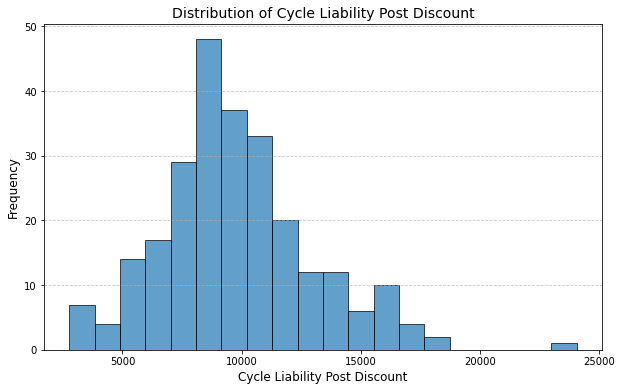

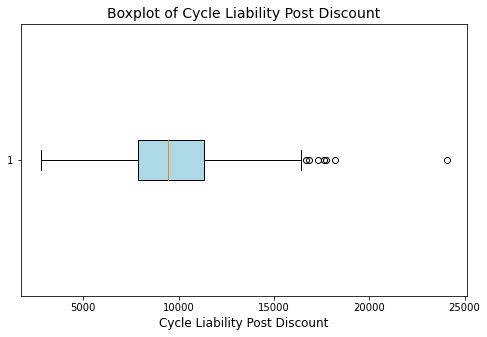

Number of Outliers: 7


,membership_id,cycle_number,cycle_liability_post_discount,clinics_id
77,clvdqa2jo00010clddqhs515j,1,18222.27,8431aa62ec764cb49b242e5561a8a136
91,clxsqnr2200010bjt8ievairb,1,24062.25,clwyuocqh000a0dkzc7ymb9l2
94,clxouv8n000010imbhkl15kqn,1,16688.80,cliomdr2o000q0cmo6275abmg
161,clumcvek000010highadq1u3o,1,17710.38,cliomdr2o000q0cmo6275abmg
179,cls4vmlgg00010dl14dqtdrn1,1,17312.24,dc46793e7417415f9798076b044b0d38
184,clzcgfslo000a0hlbgwp356co,1,16844.29,cliomdr2o000q0cmo6275abmg
218,clxaby19h00010djtgwar1kuc,1,17615.25,6967483cc92945edb383151642ec6f22


In [22]:
import matplotlib.pyplot as plt

# Basic statistics
min_liability = cycles_df['cycle_liability_post_discount'].min()
max_liability = cycles_df['cycle_liability_post_discount'].max()
mean_liability = cycles_df['cycle_liability_post_discount'].mean()
median_liability = cycles_df['cycle_liability_post_discount'].median()
std_dev_liability = cycles_df['cycle_liability_post_discount'].std()

print("Cycle Liability Post Discount - Basic Statistics:")
print(f"Minimum: {min_liability}")
print(f"Maximum: {max_liability}")
print(f"Mean: {mean_liability}")
print(f"Median: {median_liability}")
print(f"Standard Deviation: {std_dev_liability}")

# Distribution plot
plt.figure(figsize=(10, 6))
plt.hist(cycles_df['cycle_liability_post_discount'], bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Cycle Liability Post Discount", fontsize=14)
plt.xlabel("Cycle Liability Post Discount", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot to check for outliers
plt.figure(figsize=(8, 5))
plt.boxplot(cycles_df['cycle_liability_post_discount'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot of Cycle Liability Post Discount", fontsize=14)
plt.xlabel("Cycle Liability Post Discount", fontsize=12)
plt.show()

# Identify potential outliers (values beyond 1.5x IQR)
q1 = cycles_df['cycle_liability_post_discount'].quantile(0.25)
q3 = cycles_df['cycle_liability_post_discount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = cycles_df[(cycles_df['cycle_liability_post_discount'] < lower_bound) |
                     (cycles_df['cycle_liability_post_discount'] > upper_bound)]

# Display the outliers table
print(f"Number of Outliers: {len(outliers)}")
display(outliers)

### Insights from the Outliers

1. **High Values**:
    - The outlier values range from **16688.80** to **24062.25**, which are significantly above the mean (**9790.44**) and median (**9453.59**).

2. **Clinics Associated with Outliers**:
    - Out of the 7 outliers, **`cliomdr2o000q0cmo6275abmg`** appears in **3 cases**, suggesting a clinic-specific pattern.
    - Other clinics, such as **`8431aa62ec764cb49b242e5561a8a136`**, **`clwyuocqh000a0dkzc7ymb9l2`**, and **`dc46793e7417415f9798076b044b0d38`**, have a single occurrence.

3. **Single Cycle Members**:
    - All outliers are associated with **Cycle Number 1**, indicating they occur in the initial treatment cycle.


### Rounds data

In [26]:
display(rounds_df.head().style.set_table_attributes("style='display:inline'").set_caption("Rounds DataFrame"))

,membership_id,cycle_number,round_number,round_type,round_current_status
0,clr88hn3100070cl62log9v64,1,1,FROZEN_TRANSFER,PENDING_TRANSFER
1,clrhmcyo600010cjn1739f02m,2,2,ANY_IVF_WITH_FRESH_TRANSFER,TREATMENT_STARTED
2,clrhmcyo600010cjn1739f02m,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
3,clrhwsasp00080dl40mj81twz,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
4,clrkf5m7r00010cla7eio6d0b,2,1,ANY_IVF_WITH_FRESH_TRANSFER,PREGNANCY


In [24]:
# Convert column names to lowercase and replace spaces with underscores, rename the 3rd column to 'round_number'
rounds_df.columns = rounds_df.columns.str.lower().str.replace(' ', '_')
rounds_df.rename(columns={
    'round_number_(excluding_cancelled_rounds_and_counts_towards_insurance_=_true)': 'round_number'
}, inplace=True)

# High-level statistics
print("High-Level Statistics for Rounds DataFrame:")
display(rounds_df.describe(include='all'))

# Check for null values
print("\nMissing Values:")
display(rounds_df.isnull().sum())

# Check for duplicates
duplicates = rounds_df.duplicated()
print(f"\nNumber of Duplicate Rows: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("\nExample Duplicate Rows:")
    display(rounds_df[duplicates].head())

High-Level Statistics for Rounds DataFrame:


,membership_id,cycle_number,round_number,round_type,round_current_status
count,236,236.000000,236.000000,236,236
unique,199,NaN,NaN,3,7
top,cltrhc9au000i0cjvhmgc7263,NaN,NaN,ANY_IVF_WITH_FRESH_TRANSFER,PENDING
freq,3,NaN,NaN,166,84
mean,NaN,1.144068,1.186441,NaN,NaN
std,NaN,0.386483,0.460326,NaN,NaN
min,NaN,1.000000,1.000000,NaN,NaN
25%,NaN,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,1.000000,NaN,NaN
75%,NaN,1.000000,1.000000,NaN,NaN



Missing Values:


membership_id           0
cycle_number            0
round_number            0
round_type              0
round_current_status    0
dtype: int64


Number of Duplicate Rows: 0


In [40]:
# Explore distinct values of round_type and round_current_status
round_type_values = rounds_df['round_type'].unique()
round_status_values = rounds_df['round_current_status'].unique()

print("\nDistinct values for round_type:")
print(round_type_values)

print("\nDistinct values for round_current_status:")
print(round_status_values)


Distinct values for round_type:
['FROZEN_TRANSFER' 'ANY_IVF_WITH_FRESH_TRANSFER'
 'ANY_IVF_WITH_EMBRYO_FREEZING']

Distinct values for round_current_status:
['PENDING_TRANSFER' 'TREATMENT_STARTED' 'UNSUCCESSFUL' 'PREGNANCY'
 'PENDING' 'CLEARED_TO_BEGIN_TREATMENT' 'CANCELLED']


In [65]:
# Find duplicate entries based on membership_id, cycle_number, and round_number
duplicate_entries = rounds_df[rounds_df.duplicated(subset=['membership_id', 'cycle_number', 'round_number'], keep=False)]

if not duplicate_entries.empty:
    print("\nDuplicate entries based on membership_id, cycle_number, and round_number:")
    display(duplicate_entries)
else:
    print("\nNo duplicate entries found based on membership_id, cycle_number, and round_number.")



No duplicate entries found based on membership_id, cycle_number, and round_number.


In [76]:
# Identify members who went through multiple cycles
multi_cycle_members = rounds_df.groupby('membership_id')['cycle_number'].nunique()
multi_cycle_members = multi_cycle_members[multi_cycle_members > 1]

# Filter the original DataFrame for these members
multi_cycle_data = rounds_df[rounds_df['membership_id'].isin(multi_cycle_members.index)]

# Randomly select 5 members who went through multiple cycles
random_members = multi_cycle_members.sample(10, random_state=42).index

# Display data for the selected members ordered by cycle_number and round_number ASC
for member_id in random_members:
    member_data = multi_cycle_data[multi_cycle_data['membership_id'] == member_id]
    member_data = member_data.sort_values(by=['cycle_number', 'round_number'], ascending=True)
    print(f"\nData for Member ID: {member_id}")
    display(member_data)



Data for Member ID: clrhmcyo600010cjn1739f02m


,membership_id,cycle_number,round_number,round_type,round_current_status
2,clrhmcyo600010cjn1739f02m,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
1,clrhmcyo600010cjn1739f02m,2,2,ANY_IVF_WITH_FRESH_TRANSFER,TREATMENT_STARTED



Data for Member ID: cltr095r700010cl6hvxx82bt


,membership_id,cycle_number,round_number,round_type,round_current_status
37,cltr095r700010cl6hvxx82bt,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
38,cltr095r700010cl6hvxx82bt,2,2,ANY_IVF_WITH_FRESH_TRANSFER,PREGNANCY



Data for Member ID: clv5bwdln00010dl31s8v17rh


,membership_id,cycle_number,round_number,round_type,round_current_status
73,clv5bwdln00010dl31s8v17rh,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
72,clv5bwdln00010dl31s8v17rh,2,2,ANY_IVF_WITH_FRESH_TRANSFER,PENDING



Data for Member ID: clrp4kifk00010dl30y7y9s5d


,membership_id,cycle_number,round_number,round_type,round_current_status
5,clrp4kifk00010dl30y7y9s5d,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
7,clrp4kifk00010dl30y7y9s5d,2,2,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
6,clrp4kifk00010dl30y7y9s5d,2,3,FROZEN_TRANSFER,TREATMENT_STARTED



Data for Member ID: clujrhhx400010djr0hop7jxm


,membership_id,cycle_number,round_number,round_type,round_current_status
59,clujrhhx400010djr0hop7jxm,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
57,clujrhhx400010djr0hop7jxm,2,2,ANY_IVF_WITH_FRESH_TRANSFER,CANCELLED
58,clujrhhx400010djr0hop7jxm,2,3,FROZEN_TRANSFER,TREATMENT_STARTED



Data for Member ID: clwqdfqi900010dl24tug27xk


,membership_id,cycle_number,round_number,round_type,round_current_status
120,clwqdfqi900010dl24tug27xk,1,1,ANY_IVF_WITH_EMBRYO_FREEZING,CANCELLED
119,clwqdfqi900010dl24tug27xk,2,2,ANY_IVF_WITH_EMBRYO_FREEZING,TREATMENT_STARTED



Data for Member ID: clsc1oywi00010bjscbmrdo51


,membership_id,cycle_number,round_number,round_type,round_current_status
19,clsc1oywi00010bjscbmrdo51,1,1,FROZEN_TRANSFER,UNSUCCESSFUL
18,clsc1oywi00010bjscbmrdo51,2,2,ANY_IVF_WITH_FRESH_TRANSFER,PENDING



Data for Member ID: clve869zo00010bl8524sgwqc


,membership_id,cycle_number,round_number,round_type,round_current_status
80,clve869zo00010bl8524sgwqc,1,1,ANY_IVF_WITH_EMBRYO_FREEZING,UNSUCCESSFUL
79,clve869zo00010bl8524sgwqc,2,2,ANY_IVF_WITH_EMBRYO_FREEZING,UNSUCCESSFUL



Data for Member ID: clw0nafr000010jmh52x5de3n


,membership_id,cycle_number,round_number,round_type,round_current_status
100,clw0nafr000010jmh52x5de3n,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
101,clw0nafr000010jmh52x5de3n,2,2,ANY_IVF_WITH_FRESH_TRANSFER,TREATMENT_STARTED



Data for Member ID: clx91g833000t0dl8a3pcfn7n


,membership_id,cycle_number,round_number,round_type,round_current_status
132,clx91g833000t0dl8a3pcfn7n,1,1,ANY_IVF_WITH_EMBRYO_FREEZING,UNSUCCESSFUL
131,clx91g833000t0dl8a3pcfn7n,2,2,ANY_IVF_WITH_EMBRYO_FREEZING,TREATMENT_STARTED


In [77]:
# Check round progression across cycles for members with multiple cycles
multi_cycle_members = rounds_df.groupby('membership_id')['cycle_number'].nunique()
multi_cycle_data = rounds_df[rounds_df['membership_id'].isin(multi_cycle_members[multi_cycle_members > 1].index)]
round_progression = multi_cycle_data.sort_values(by=['membership_id', 'cycle_number', 'round_number'])
display(round_progression)


,membership_id,cycle_number,round_number,round_type,round_current_status
2,clrhmcyo600010cjn1739f02m,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
1,clrhmcyo600010cjn1739f02m,2,2,ANY_IVF_WITH_FRESH_TRANSFER,TREATMENT_STARTED
5,clrp4kifk00010dl30y7y9s5d,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
7,clrp4kifk00010dl30y7y9s5d,2,2,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
6,clrp4kifk00010dl30y7y9s5d,2,3,FROZEN_TRANSFER,TREATMENT_STARTED
17,clsbq8w3q00010mjo5ydteyn5,2,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL
16,clsbq8w3q00010mjo5ydteyn5,3,2,ANY_IVF_WITH_FRESH_TRANSFER,PENDING
19,clsc1oywi00010bjscbmrdo51,1,1,FROZEN_TRANSFER,UNSUCCESSFUL
18,clsc1oywi00010bjscbmrdo51,2,2,ANY_IVF_WITH_FRESH_TRANSFER,PENDING
21,clsog29bz00010djxg33sbfyq,1,3,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL


## Analysis of Round Number Sequence Within Cycles

### 1. **Expected Behavior**
- A new `cycle_number` should typically start with `round_number = 1`.
- Subsequent rounds (`round_number = 2`, `round_number = 3`, etc.) occur within the same cycle.

### 2. **Observed Issues**
- **Missing or Skipped Round 1**:
  - Some cycles do not start with `round_number = 1`.
    - Example: `clrhmcyo600010cjn1739f02m` in `cycle_number = 2` starts at `round_number = 2`.
  - Possible reasons:
    - Data entry errors.
    - Skipped or canceled rounds not explicitly marked in the data.

- **Examples**:
  - Member `clsbq8w3q00010mjo5ydteyn5`:
    - `round_number = 1` exists in `cycle_number = 2` but starts with `round_number = 2` in `cycle_number = 3`.
  - Member `clsc1oywi00010bjscbmrdo51`:
    - Starts directly at `round_number = 2` in `cycle_number = 2`.


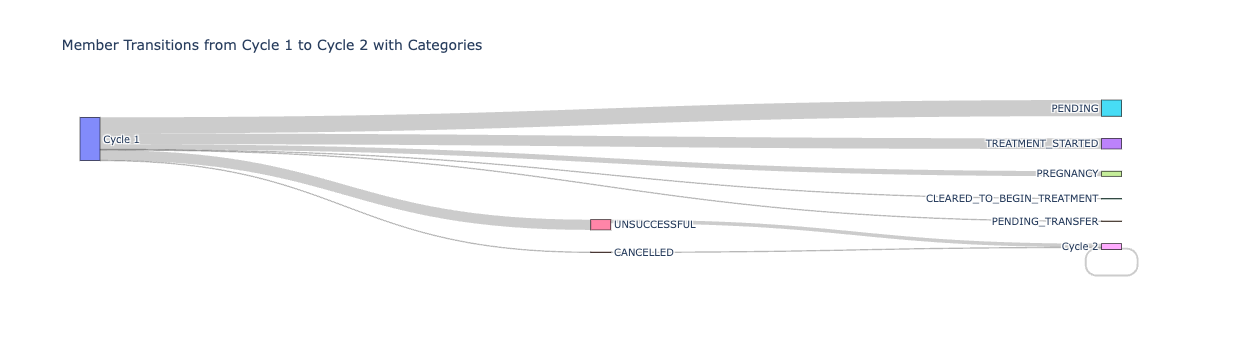

In [105]:
# Define statuses of interest
statuses = ["CANCELLED", "CLEARED_TO_BEGIN_TREATMENT", "TREATMENT_STARTED", "PENDING_TRANSFER", 
            "PENDING", "UNSUCCESSFUL", "PREGNANCY"]

# Unique members in Cycle 1 (distinct by membership_id, cycle_number, and round_number)
unique_cycle_1_members = rounds_df[rounds_df['cycle_number'] == 1].drop_duplicates(subset=['membership_id', 'cycle_number', 'round_number'])

# Categorize members in Cycle 1 by their statuses
category_counts_cycle_1 = {}
for status in statuses:
    category_counts_cycle_1[status] = unique_cycle_1_members[unique_cycle_1_members['round_current_status'] == status]['membership_id'].unique()

# Members in Cycle 2 originating from Cycle 1
unique_cycle_2_members = rounds_df[rounds_df['cycle_number'] == 2].drop_duplicates(subset=['membership_id', 'cycle_number', 'round_number'])
members_from_cycle_1 = unique_cycle_2_members[unique_cycle_2_members['membership_id'].isin(unique_cycle_1_members['membership_id'])]

# Members in Cycle 2 who did not go through Cycle 1
members_skipped_cycle_1 = unique_cycle_2_members[~unique_cycle_2_members['membership_id'].isin(unique_cycle_1_members['membership_id'])]

# Categorize members in Cycle 2 by their statuses
category_counts_cycle_2 = {}
for status in statuses:
    category_counts_cycle_2[status] = members_from_cycle_1[members_from_cycle_1['round_current_status'] == status]['membership_id'].unique()

# Prepare data for Sankey diagram
import plotly.graph_objects as go

source, target, value = [], [], []

# From Cycle 1 to Each Status
exit_index_start = 1  # Index of first status category
for i, status in enumerate(statuses):
    members_in_status = category_counts_cycle_1[status]
    if len(members_in_status) > 0:
        source.append(0)  # Stage 1 index (Cycle 1)
        target.append(exit_index_start + i)  # Index for this status
        value.append(len(members_in_status))

# From Each Status in Cycle 1 to Cycle 2
cycle_2_index = len(statuses) + 1
for i, status in enumerate(statuses):
    members_in_status = category_counts_cycle_1[status]
    members_in_cycle_2 = members_from_cycle_1[members_from_cycle_1['membership_id'].isin(members_in_status)]
    if len(members_in_cycle_2) > 0:
        source.append(exit_index_start + i)  # Index for this status
        target.append(cycle_2_index)  # Index for Cycle 2
        value.append(len(members_in_cycle_2))

# Add skipped members to Cycle 2
if len(members_skipped_cycle_1) > 0:
    source.append(len(statuses) + 1)  # Skipped index
    target.append(cycle_2_index)  # Index for Cycle 2
    value.append(len(members_skipped_cycle_1))

# Define node labels
labels = ["Cycle 1"] + statuses + ["Cycle 2", "Skipped Cycle 1"]

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Member Transitions from Cycle 1 to Cycle 2 with Categories", font_size=10)
fig.show()


Unique members in Cycle 2: 28
Members with status CANCELLED in Cycle 2: 1
Members with status CLEARED_TO_BEGIN_TREATMENT in Cycle 2: 0
Members with status TREATMENT_STARTED in Cycle 2: 9
Members with status PENDING_TRANSFER in Cycle 2: 0
Members with status PENDING in Cycle 2: 6
Members with status UNSUCCESSFUL in Cycle 2: 7
Members with status PREGNANCY in Cycle 2: 5
Members in Cycle 3 from Cycle 2: 2
Members in Cycle 3 who did not go through Cycle 2: 1
Members with status CANCELLED in Cycle 3: 0
Members with status CLEARED_TO_BEGIN_TREATMENT in Cycle 3: 0
Members with status TREATMENT_STARTED in Cycle 3: 0
Members with status PENDING_TRANSFER in Cycle 3: 0
Members with status PENDING in Cycle 3: 2
Members with status UNSUCCESSFUL in Cycle 3: 0
Members with status PREGNANCY in Cycle 3: 0


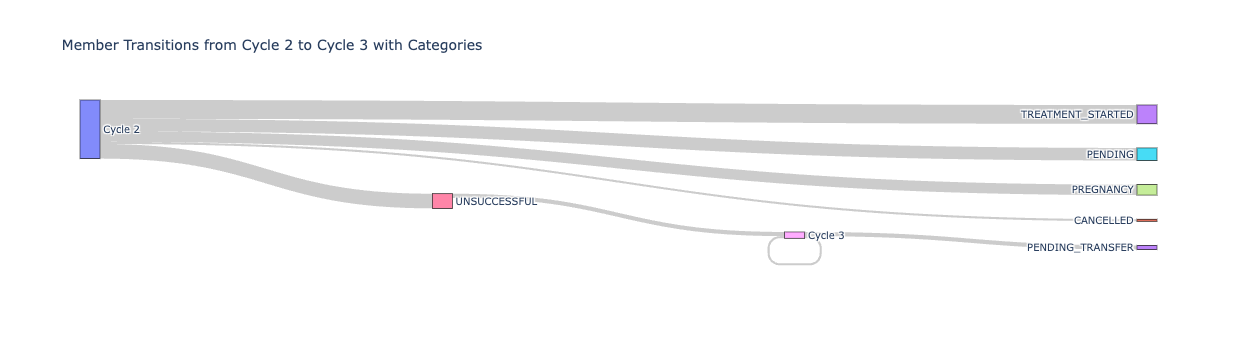

In [106]:
# Create the Sankey diagram: Cycle 2 to Cycle 3 transitions

# Define statuses of interest
statuses = ["CANCELLED", "CLEARED_TO_BEGIN_TREATMENT", "TREATMENT_STARTED", "PENDING_TRANSFER", 
            "PENDING", "UNSUCCESSFUL", "PREGNANCY"]

# Unique members in Cycle 2 (distinct by membership_id, cycle_number, and round_number)
unique_cycle_2_members = rounds_df[rounds_df['cycle_number'] == 2].drop_duplicates(subset=['membership_id', 'cycle_number', 'round_number'])
print(f"Unique members in Cycle 2: {len(unique_cycle_2_members)}")

# Categorize members in Cycle 2 by their statuses
category_counts_cycle_2 = {}
for status in statuses:
    category_counts_cycle_2[status] = unique_cycle_2_members[unique_cycle_2_members['round_current_status'] == status]['membership_id'].unique()
    print(f"Members with status {status} in Cycle 2: {len(category_counts_cycle_2[status])}")

# Members in Cycle 3 originating from Cycle 2
unique_cycle_3_members = rounds_df[rounds_df['cycle_number'] == 3].drop_duplicates(subset=['membership_id', 'cycle_number', 'round_number'])
members_from_cycle_2 = unique_cycle_3_members[unique_cycle_3_members['membership_id'].isin(unique_cycle_2_members['membership_id'])]
print(f"Members in Cycle 3 from Cycle 2: {len(members_from_cycle_2)}")

# Members in Cycle 3 who did not go through Cycle 2
members_skipped_cycle_2 = unique_cycle_3_members[~unique_cycle_3_members['membership_id'].isin(unique_cycle_2_members['membership_id'])]
print(f"Members in Cycle 3 who did not go through Cycle 2: {len(members_skipped_cycle_2)}")

# Categorize members in Cycle 3 by their statuses
category_counts_cycle_3 = {}
for status in statuses:
    category_counts_cycle_3[status] = members_from_cycle_2[members_from_cycle_2['round_current_status'] == status]['membership_id'].unique()
    print(f"Members with status {status} in Cycle 3: {len(category_counts_cycle_3[status])}")

# Prepare data for Sankey diagram
import plotly.graph_objects as go

source, target, value = [], [], []

# From Cycle 2 to Each Status
exit_index_start = 1  # Index of first status category
for i, status in enumerate(statuses):
    members_in_status = category_counts_cycle_2[status]
    if len(members_in_status) > 0:
        source.append(0)  # Stage 1 index (Cycle 2)
        target.append(exit_index_start + i)  # Index for this status
        value.append(len(members_in_status))

# From Each Status in Cycle 2 to Cycle 3
cycle_3_index = len(statuses) + 1
for i, status in enumerate(statuses):
    members_in_status = category_counts_cycle_2[status]
    members_in_cycle_3 = members_from_cycle_2[members_from_cycle_2['membership_id'].isin(members_in_status)]
    if len(members_in_cycle_3) > 0:
        source.append(exit_index_start + i)  # Index for this status
        target.append(cycle_3_index)  # Index for Cycle 3
        value.append(len(members_in_cycle_3))

# Add skipped members to Cycle 3
if len(members_skipped_cycle_2) > 0:
    source.append(len(statuses) + 1)  # Skipped index
    target.append(cycle_3_index)  # Index for Cycle 3
    value.append(len(members_skipped_cycle_2))

# From Cycle 3 to Each Status
exit_index_start_cycle_3 = len(statuses) + 2
for i, status in enumerate(statuses):
    members_in_status = category_counts_cycle_3[status]
    if len(members_in_status) > 0:
        source.append(cycle_3_index)  # Stage 3 index (Cycle 3)
        target.append(exit_index_start_cycle_3 + i)  # Index for this status in Cycle 3
        value.append(len(members_in_status))

# Define node labels
labels = ["Cycle 2"] + statuses + ["Cycle 3", "Skipped Cycle 2"] + statuses

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Member Transitions from Cycle 2 to Cycle 3 with Categories", font_size=10)
fig.show()


In [107]:
# Calculate the success rate (PREGNANCY proportion) for Cycle 1 and Cycle 2

# Filter data for PREGNANCY and UNSUCCESSFUL statuses
filtered_status = rounds_df[rounds_df['round_current_status'].isin(['PREGNANCY', 'UNSUCCESSFUL'])]

# Calculate success rate for Cycle 1
cycle_1_status = filtered_status[filtered_status['cycle_number'] == 1]
cycle_1_status_no_duplicates = cycle_1_status.drop_duplicates(subset=['membership_id'], keep='first')

pregnancy_count_cycle_1 = (cycle_1_status_no_duplicates['round_current_status'] == 'PREGNANCY').sum()
total_filtered_cycle_1 = len(cycle_1_status_no_duplicates)
success_rate_cycle_1 = pregnancy_count_cycle_1 / total_filtered_cycle_1 * 100

# Calculate success rate for Cycle 2
cycle_2_status = filtered_status[filtered_status['cycle_number'] == 2]
cycle_2_status_no_duplicates = cycle_2_status.drop_duplicates(subset=['membership_id'], keep='first')

pregnancy_count_cycle_2 = (cycle_2_status_no_duplicates['round_current_status'] == 'PREGNANCY').sum()
total_filtered_cycle_2 = len(cycle_2_status_no_duplicates)
success_rate_cycle_2 = pregnancy_count_cycle_2 / total_filtered_cycle_2 * 100

# Print the results
print("\nSuccess Rate Calculation:")
print(f"Cycle 1 - Total Members After Filtering: {total_filtered_cycle_1}")
print(f"Cycle 1 - Number of Successful (PREGNANCY): {pregnancy_count_cycle_1}")
print(f"Cycle 1 - Success Rate: {success_rate_cycle_1:.2f}%")

print(f"\nCycle 2 - Total Members After Filtering: {total_filtered_cycle_2}")
print(f"Cycle 2 - Number of Successful (PREGNANCY): {pregnancy_count_cycle_2}")
print(f"Cycle 2 - Success Rate: {success_rate_cycle_2:.2f}%")



Success Rate Calculation:
Cycle 1 - Total Members After Filtering: 71
Cycle 1 - Number of Successful (PREGNANCY): 24
Cycle 1 - Success Rate: 33.80%

Cycle 2 - Total Members After Filtering: 12
Cycle 2 - Number of Successful (PREGNANCY): 5
Cycle 2 - Success Rate: 41.67%


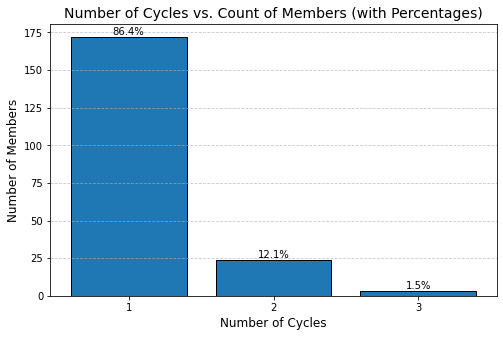

In [66]:
# Aggregate data to count the number of cycles per member
cycle_counts = rounds_df.groupby('membership_id')['cycle_number'].max()
cycle_distribution = cycle_counts.value_counts().sort_index()

# Calculate percentages
total_members = cycle_distribution.sum()
percentage_distribution = (cycle_distribution / total_members) * 100

# Plot the distribution with percentages
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(cycle_distribution.index, cycle_distribution, edgecolor='black', label='Number of Members')

# Annotate bars with percentages
for bar, percentage in zip(bars, percentage_distribution):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage:.1f}%", 
            ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_title("Number of Cycles vs. Count of Members (with Percentages)", fontsize=14)
ax.set_xlabel("Number of Cycles", fontsize=12)
ax.set_ylabel("Number of Members", fontsize=12)
ax.set_xticks(cycle_distribution.index)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Number of discrepancies where members and cycle numbers are missing in rounds_df: 37
Number of discrepancies where members and cycle numbers are missing in cycles_df: 0

Examples of members and cycles missing in rounds_df:


,membership_id,cycle_number,_merge
7,clteh44db00010dldddvphpcq,1,left_only
9,clt8gc5eu00010djv3i3w7cu8,1,left_only
12,cm04ztff200010dl2hycf2e5j,1,left_only
16,clumrkpp100010bkydx7y5dy4,1,left_only
19,cluwmw5hd00010cjmafwwgl30,1,left_only


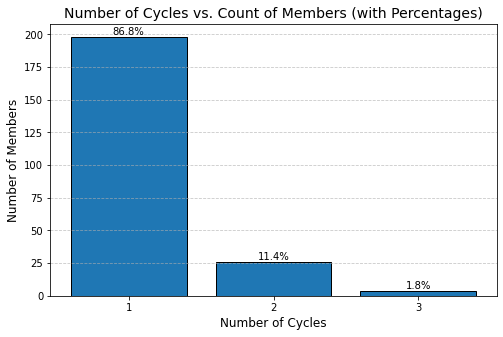

In [67]:
import matplotlib.pyplot as plt

# Validate members and cycle numbers consistency between cycles_df and rounds_df
cycles_members_cycles = cycles_df[['membership_id', 'cycle_number']].drop_duplicates()
rounds_members_cycles = rounds_df[['membership_id', 'cycle_number']].drop_duplicates()

# Find discrepancies
discrepancies = cycles_members_cycles.merge(rounds_members_cycles, on=['membership_id', 'cycle_number'], how='outer', indicator=True)
missing_in_rounds = discrepancies[discrepancies['_merge'] == 'left_only']
missing_in_cycles = discrepancies[discrepancies['_merge'] == 'right_only']

print(f"Number of discrepancies where members and cycle numbers are missing in rounds_df: {len(missing_in_rounds)}")
print(f"Number of discrepancies where members and cycle numbers are missing in cycles_df: {len(missing_in_cycles)}")

if not missing_in_rounds.empty:
    print("\nExamples of members and cycles missing in rounds_df:")
    display(missing_in_rounds.head())

if not missing_in_cycles.empty:
    print("\nExamples of members and cycles missing in cycles_df:")
    display(missing_in_cycles.head())

# Aggregate data to count the number of cycles per member
cycle_counts = cycles_df.groupby('membership_id')['cycle_number'].max()
cycle_distribution = cycle_counts.value_counts().sort_index()

# Calculate percentages
total_members = cycle_distribution.sum()
percentage_distribution = (cycle_distribution / total_members) * 100

# Plot the distribution with percentages
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(cycle_distribution.index, cycle_distribution, edgecolor='black', label='Number of Members')

# Annotate bars with percentages
for bar, percentage in zip(bars, percentage_distribution):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage:.1f}%", 
            ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_title("Number of Cycles vs. Count of Members (with Percentages)", fontsize=14)
ax.set_xlabel("Number of Cycles", fontsize=12)
ax.set_ylabel("Number of Members", fontsize=12)
ax.set_xticks(cycle_distribution.index)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Analysis of Discrepancy

### Overview
The results indicate that **37 members with corresponding cycle numbers are present in `cycles_df` but missing in `rounds_df`**, while there are no discrepancies in the other direction (`rounds_df` missing from `cycles_df`).

### Possible Reasons for Missing Rounds
1. **Data Entry Issues**:
   - Cycles may have been recorded in `cycles_df` but not updated in `rounds_df`.

2. **Canceled or Incomplete Cycles**:
   - Certain cycles may have been canceled or deferred and not included in `rounds_df`.

3. **Differences in Business Rules**:
   - The inclusion criteria for `cycles_df` and `rounds_df` might differ (e.g., canceled treatments might be excluded from `rounds_df`).


In [32]:
# Find entries missing in rounds_df
missing_in_rounds = cycles_df.merge(rounds_df, on=['membership_id', 'cycle_number'], how='left', indicator=True)
missing_cycles = missing_in_rounds[missing_in_rounds['_merge'] == 'left_only']

# Display the data entries from cycles_df that are missing in rounds_df
print(f"Number of missing entries in rounds_df: {len(missing_cycles)}")
display(missing_cycles)


Number of missing entries in rounds_df: 37


,membership_id,cycle_number,cycle_liability_post_discount,clinics_id,round_number,round_type,round_current_status,_merge
8,clteh44db00010dldddvphpcq,1,8177.83,51ee7c940ea14feeb5bd1f64b2776fdd,NaN,NaN,NaN,left_only
10,clt8gc5eu00010djv3i3w7cu8,1,10862.70,clmqb6tsx00050jmhelshbqde,NaN,NaN,NaN,left_only
13,cm04ztff200010dl2hycf2e5j,1,9582.56,d83295faca2847aea5b2967865cf68b6,NaN,NaN,NaN,left_only
17,clumrkpp100010bkydx7y5dy4,1,6185.69,acdba87c-af1e-4122-a8d5-de1d5bd18254,NaN,NaN,NaN,left_only
20,cluwmw5hd00010cjmafwwgl30,1,7889.33,3ac907157d7f44ec8a5177ca5402c398,NaN,NaN,NaN,left_only
21,clt5puckd00010dkzde5286m9,1,8379.72,fd150b6165d64c008f0b708b554b3200,NaN,NaN,NaN,left_only
23,clu12l3hj00010bl9eo8qfroo,1,10422.81,c1919b2c63a047bcb5c4fc871ae68372,NaN,NaN,NaN,left_only
28,cls2z6ewt00040bjs5r81alyr,1,4255.84,f6bef049db3d47bcb0e32f89b3e36d09,NaN,NaN,NaN,left_only
31,cltgy3jji00010bjzbbuzft96,1,5371.22,clepzgncm00050djk1x3fgndm,NaN,NaN,NaN,left_only
32,cluwn6rc700010dk035ve45hq,1,8674.30,54c97730c0c44b56b7f244131add4b71,NaN,NaN,NaN,left_only


## Analysis of Missing Entries in `rounds_df`

### Key Observations

1. **Reasons**:
     - Canceled rounds.
     - Data entry omissions.
     - Business logic where certain cycles do not require rounds.

2. **Cycle Liability Exists for All Missing Entries**:
   - The `cycle_liability_post_discount` column has valid values for all these entries in `cycles_df`.

3. **Distribution of Missing Entries**:
   - Most entries (33 out of 37 = 90%) are associated with `cycle_number = 1`.
   - A few entries, such as `cltwqnl8000010ll8005thww0` and `cluwkrgnf00010bk25kic02pf`, have higher cycle numbers (`cycle_number = 2` or `3`).

In [33]:
print("Summary of Cycle Liabilities for Missing Entries:")
display(missing_cycles['cycle_liability_post_discount'].describe())


Summary of Cycle Liabilities for Missing Entries:


count       37.000000
mean      9430.487027
std       3060.206048
min       3332.990000
25%       7889.330000
50%       9038.360000
75%      10884.630000
max      18222.270000
Name: cycle_liability_post_discount, dtype: float64

In [34]:
higher_cycle_numbers = missing_cycles[missing_cycles['cycle_number'] > 1]
display(higher_cycle_numbers)

,membership_id,cycle_number,cycle_liability_post_discount,clinics_id,round_number,round_type,round_current_status,_merge
251,clssw7fkh00010cl952lw5hik,2,11177.66,clisp8fir001c0cmh05mk3xdm,NaN,NaN,NaN,left_only
252,clsbqz2mr00010bl73z999sbh,2,7577.70,68209e6ce6304a27930f9e2e6b132466,NaN,NaN,NaN,left_only
267,cltwqnl8000010ll8005thww0,2,7295.07,3bcb2e8b040a48458a981261654a5593,NaN,NaN,NaN,left_only
272,cluwkrgnf00010bk25kic02pf,3,10563.01,clgkl7ngy004w0jmsg1aj41sa,NaN,NaN,NaN,left_only


In [35]:
missing_clinics = missing_cycles['clinics_id'].value_counts()
display(missing_clinics)

clpjlnr6100070dl3d9wj81bb               3
3bcb2e8b040a48458a981261654a5593        3
8431aa62ec764cb49b242e5561a8a136        2
d8462f9d50d24586aee405ba1c356fd1        2
3ac907157d7f44ec8a5177ca5402c398        2
clisp8fir001c0cmh05mk3xdm               2
68209e6ce6304a27930f9e2e6b132466        1
9693ce28f4e84132bafd3ecafac63cf1        1
205e8f7cd5574d0bb1e3edd944705814        1
50dd9c2efb514775bf810eb393c9b669        1
98cbc52929df43d8964557df7ba6b1e9        1
e56bdf9dd4d0468293568488afece52a        1
cliomdr2o000q0cmo6275abmg               1
f41eb7e430e34ce183e3a5f433f9aaec        1
114feefce3064eb096c8e71174126ef8        1
55bfff2e54de4bfd8c01c74bbc4b0b4f        1
51ee7c940ea14feeb5bd1f64b2776fdd        1
b1f0581d86bd4c6c818c7d596aa4053f        1
clmqb6tsx00050jmhelshbqde               1
ed236c69937b44678dcd6875393d8cc5        1
83c6da596e60430aac0e5608a0a15a17        1
54c97730c0c44b56b7f244131add4b71        1
clepzgncm00050djk1x3fgndm               1
f6bef049db3d47bcb0e32f89b3e36d09  

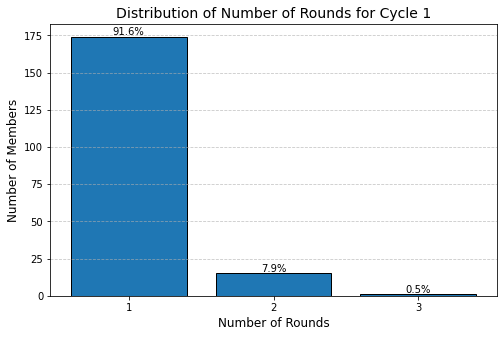

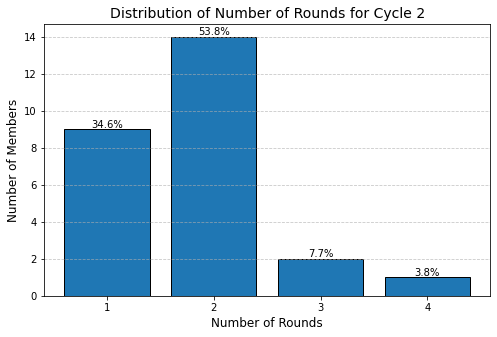

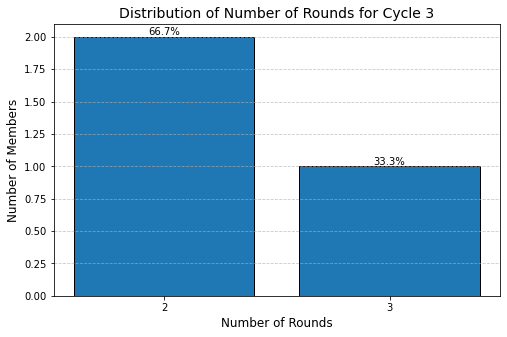

In [38]:
# Bar plots for distribution of the number of rounds per cycle_number categories
for cycle_num in [1, 2, 3]:
    subset = rounds_df[rounds_df['cycle_number'] == cycle_num]
    round_counts = subset.groupby('membership_id')['round_number'].max()
    round_distribution = round_counts.value_counts().sort_index()

    # Calculate percentages
    total_members = round_distribution.sum()
    percentage_distribution = (round_distribution / total_members) * 100

    # Plot the distribution with percentages
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(round_distribution.index, round_distribution, edgecolor='black', label=f'Cycle {cycle_num}')

    # Annotate bars with percentages
    for bar, percentage in zip(bars, percentage_distribution):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage:.1f}%", 
                ha='center', va='bottom', fontsize=10)

    # Customize the plot
    ax.set_title(f"Distribution of Number of Rounds for Cycle {cycle_num}", fontsize=14)
    ax.set_xlabel("Number of Rounds", fontsize=12)
    ax.set_ylabel("Number of Members", fontsize=12)
    ax.set_xticks(round_distribution.index)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### 1. **Cycle 1 High Success Rates**
- The high percentage of members achieving success with **1 round (91.58%)** in Cycle 1 could reflect the effectiveness of Gaia's ML model in identifying high-probability candidates.
- The model likely filters out candidates with low chances of success early, ensuring that most selected members succeed in fewer rounds.

### 2. **Cycle 2 Complexity**
- The proportion of members requiring multiple rounds increases significantly compared to Cycle 1 (**53.85% need 2 rounds**), potentially indicating more complex cases.
- This suggests that Cycle 2 includes more challenging cases where initial success was not achieved.

### 3. **Cycle 3 Complexity**
- A very small sample size, but a majority still need **2 rounds (66.67%)**, with some requiring **3 rounds (33.33%)**.
- This reflects the increasing difficulty of cases progressing to Cycle 3 and the need for more intensive treatments.



Distribution of round_type:


ANY_IVF_WITH_FRESH_TRANSFER     166
ANY_IVF_WITH_EMBRYO_FREEZING     45
FROZEN_TRANSFER                  25
Name: round_type, dtype: int64

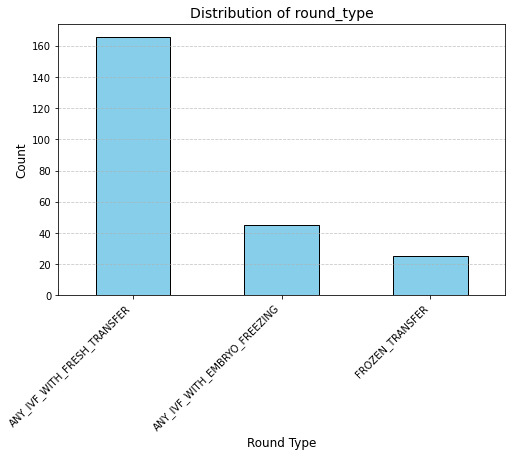


Distribution of round_current_status:


PENDING                       84
TREATMENT_STARTED             61
UNSUCCESSFUL                  55
PREGNANCY                     29
CANCELLED                      3
PENDING_TRANSFER               2
CLEARED_TO_BEGIN_TREATMENT     2
Name: round_current_status, dtype: int64

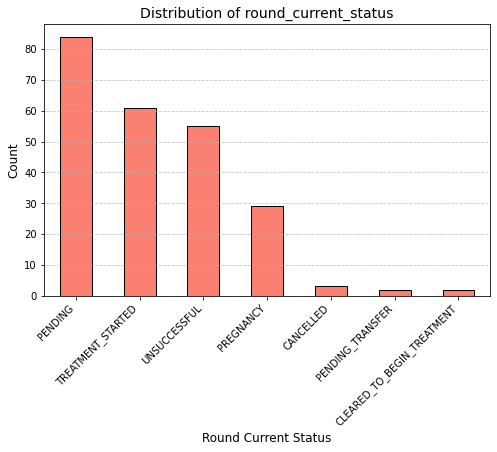

In [45]:
# Distribution of round_type
round_type_distribution = rounds_df['round_type'].value_counts()
print("Distribution of round_type:")
display(round_type_distribution)

# Bar plot for round_type distribution
round_type_distribution.plot(kind='bar', figsize=(8, 5), edgecolor='black', color='skyblue')
plt.title("Distribution of round_type", fontsize=14)
plt.xlabel("Round Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Distribution of round_current_status
round_status_distribution = rounds_df['round_current_status'].value_counts()
print("\nDistribution of round_current_status:")
display(round_status_distribution)

# Bar plot for round_current_status distribution
round_status_distribution.plot(kind='bar', figsize=(8, 5), edgecolor='black', color='salmon')
plt.title("Distribution of round_current_status", fontsize=14)
plt.xlabel("Round Current Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [64]:
# Cross-tabulation of round_current_status by round_type with specified column order
status_by_type = rounds_df.pivot_table(
    index='round_type', 
    columns='round_current_status', 
    aggfunc='size', 
    fill_value=0
)

# Reorder the columns as specified
desired_order = ['CANCELLED', 'CLEARED_TO_BEGIN_TREATMENT', 'TREATMENT_STARTED', 
                 'PENDING_TRANSFER', 'PENDING', 'UNSUCCESSFUL', 'PREGNANCY']
status_by_type = status_by_type[desired_order]

print("\nRound current status distribution by round_type:")
display(status_by_type)



Round current status distribution by round_type:


round_current_status,CANCELLED,CLEARED_TO_BEGIN_TREATMENT,TREATMENT_STARTED,PENDING_TRANSFER,PENDING,UNSUCCESSFUL,PREGNANCY
round_type,,,,,,,
ANY_IVF_WITH_EMBRYO_FREEZING,1,2,19,0,11,9,3
ANY_IVF_WITH_FRESH_TRANSFER,2,0,34,1,62,44,23
FROZEN_TRANSFER,0,0,8,1,11,2,3


## Invoices

In [119]:
display(invoices_df.head().style.set_table_attributes("style='display:inline'").set_caption("Invoices DataFrame"))
print("Shape invoices table (rows, cols) =",invoices_df.shape)

,invoice_id,membership_id,round_num,supplier_type,gross_total_amount,gross_treatment_amount,gross_medication_amount,gross_other_amount
0,1yZASciiIWWCsR7MDpxCoKRY1ldGcFSk_,cm06sxge500010dl4cwc66pqa,1,CLINIC,500.000000,0.000000,0.000000,500.000000
1,cm0p1vesa00080dl22xlc8qnu,cm06sxge500010dl4cwc66pqa,1,CLINIC,523.600000,0.000000,0.000000,523.600000
2,clzwotplq000r0dlc8cro0evx,clwtc0ngg00010bmf3jc3hb7z,1,CLINIC,2645.000000,0.000000,2645.000000,0.000000
3,1Xr7Rar9Kd70ze1qFSumQDYpMbtx2FHvD_1,clu11m89e00010cl4ghgggguo,2,CLINIC,2385.000000,0.000000,0.000000,2385.000000
4,clybzap5x00090dlc9ye05cth,clu11m89e00010cl4ghgggguo,1,CLINIC,3156.760000,0.000000,3156.760000,0.000000


Shape invoices table (rows, cols) = (817, 8)


In [49]:
# Explore the invoices data

# Convert column names to lowercase and replace spaces with underscores
invoices_df.columns = invoices_df.columns.str.lower().str.replace(' ', '_')

# Check for missing values
print("Missing values in Invoices DataFrame:")
display(invoices_df.isnull().sum())

# Basic statistics for numeric columns
print("\nSummary Statistics for Invoices DataFrame:")
display(invoices_df.describe())

# Check for duplicates
duplicates_invoices = invoices_df.duplicated()
print(f"\nNumber of Duplicate Rows in Invoices DataFrame: {duplicates_invoices.sum()}")

# Ensure all expected columns exist
required_columns = ['treatment_amount', 'medication_amount', 'other_amount', 'overall_total']
missing_columns = [col for col in required_columns if col not in invoices_df.columns]
if missing_columns:
    print(f"\nMissing columns in Invoices DataFrame: {missing_columns}")
else:
    # Aggregate totals for treatment, medication, and other amounts
    total_treatment = invoices_df['treatment_amount'].sum()
    total_medication = invoices_df['medication_amount'].sum()
    total_other = invoices_df['other_amount'].sum()
    total_overall = invoices_df['overall_total'].sum()

    print("\nAggregate Totals:")
    print(f"Total Treatment Amount: {total_treatment}")
    print(f"Total Medication Amount: {total_medication}")
    print(f"Total Other Amounts: {total_other}")
    print(f"Overall Total: {total_overall}")

    # Distribution plots for numeric columns
    import matplotlib.pyplot as plt

    numeric_columns = ['treatment_amount', 'medication_amount', 'other_amount', 'overall_total']
    for column in numeric_columns:
        plt.figure(figsize=(8, 5))
        invoices_df[column].plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
        plt.title(f"Distribution of {column}", fontsize=14)
        plt.xlabel(column.replace('_', ' ').title(), fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


Missing values in Invoices DataFrame:


invoice_id                 0
membership_id              0
round_num                  0
supplier_type              0
gross_total_amount         0
gross_treatment_amount     0
gross_medication_amount    0
gross_other_amount         0
dtype: int64


Summary Statistics for Invoices DataFrame:


,round_num,gross_total_amount,gross_treatment_amount,gross_medication_amount,gross_other_amount
count,817.000000,817.000000,817.000000,817.000000,817.000000
mean,1.236230,2084.347972,1051.728656,419.611601,613.007714
std,0.865606,2749.048412,2438.025469,731.085349,1710.947276
min,1.000000,-5405.000000,-5405.000000,-2720.000000,-3036.000000
25%,1.000000,190.260000,0.000000,0.000000,0.000000
50%,1.000000,961.000000,0.000000,73.000000,0.000000
75%,1.000000,2715.909091,39.420000,498.000000,0.000000
max,9.000000,15250.000000,15250.000000,6374.000000,13650.000000



Number of Duplicate Rows in Invoices DataFrame: 0

Missing columns in Invoices DataFrame: ['treatment_amount', 'medication_amount', 'other_amount', 'overall_total']


## Joining all 3 tables

In [124]:
# Join the three tables by keeping only the members who appear in the cycles table

# Merge cycles with rounds on membership_id
merged_data = cycles_df.merge(rounds_df, on='membership_id', how='inner')

# Merge the result with invoices on membership_id
merged_data = merged_data.merge(invoices_df, on='membership_id', how='inner')

# Display the resulting merged table
print("\nMerged Data Shape:")
print(merged_data.shape)
display(merged_data.head())



Merged Data Shape:
(1131, 15)


,membership_id,cycle_number_x,cycle_liability_post_discount,clinics_id,cycle_number_y,round_number,round_type,round_current_status,invoice_id,round_num,supplier_type,gross_total_amount,gross_treatment_amount,gross_medication_amount,gross_other_amount
0,cltqx2w4q00010ml1fhm9hy32,1,6283.40,7ebcc0c8d77d42309ab6dae22beb6e9a,1,1,ANY_IVF_WITH_FRESH_TRANSFER,PREGNANCY,clv3mza4c001p0dld9yeqh3ui,1,CLINIC,4000.0,4000.0,0.0,0.0
1,clrhwsasp00080dl40mj81twz,1,7661.02,ed236c69937b44678dcd6875393d8cc5,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL,clsly50jx000r0dld7z8d4jl6,1,CLINIC,5035.0,5035.0,0.0,0.0
2,clrhwsasp00080dl40mj81twz,1,7661.02,ed236c69937b44678dcd6875393d8cc5,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL,cltcruepg00090dl49sihbmsi,1,CLINIC,163.6,100.0,63.6,0.0
3,clrhwsasp00080dl40mj81twz,1,7661.02,ed236c69937b44678dcd6875393d8cc5,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL,clslsuzup00050djreioygfpx,1,CLINIC,216.0,0.0,216.0,0.0
4,clrhwsasp00080dl40mj81twz,1,7661.02,ed236c69937b44678dcd6875393d8cc5,1,1,ANY_IVF_WITH_FRESH_TRANSFER,UNSUCCESSFUL,clrs2t5iq00080cjldf1uan3j,1,CLINIC,678.0,0.0,678.0,0.0



PNL Summary for All Round Current Status:


,mean,sum,min,max
round_current_status,,,,
CANCELLED,1886.444706,"64,139.12",-4099.840000,4373.540000
CLEARED_TO_BEGIN_TREATMENT,12561.305000,"75,367.83",7043.270000,20651.250000
PENDING,6896.610704,"1,255,183.15",-19.282727,15494.038182
PENDING_TRANSFER,10609.164545,"116,700.81",4946.670000,14012.590000
PREGNANCY,9019.777569,"1,966,311.51",-110.040000,17389.380000
TREATMENT_STARTED,6641.669024,"1,620,567.24",-4099.840000,17957.750000
UNSUCCESSFUL,7062.004233,"3,079,033.85",-4020.000000,15348.780000



Members Who Made Gaia Lose Money:


,membership_id,cycle_liability_post_discount,gross_total_amount,pnl
26,cltr095r700010cl6hvxx82bt,6383.96,6494.000000,-110.040000
32,cltr095r700010cl6hvxx82bt,6383.96,6494.000000,-110.040000
38,cltr095r700010cl6hvxx82bt,6383.96,6494.000000,-110.040000
44,cltr095r700010cl6hvxx82bt,6383.96,6494.000000,-110.040000
209,clsbn2cjp00010dld1l5c3pdk,5920.48,7110.000000,-1189.520000
317,clsbq8w3q00010mjo5ydteyn5,3332.99,3352.272727,-19.282727
320,clsbq8w3q00010mjo5ydteyn5,3332.99,3352.272727,-19.282727
323,clsbq8w3q00010mjo5ydteyn5,3332.99,3352.272727,-19.282727
326,clsbq8w3q00010mjo5ydteyn5,3332.99,3352.272727,-19.282727
329,clsbq8w3q00010mjo5ydteyn5,3332.99,3352.272727,-19.282727


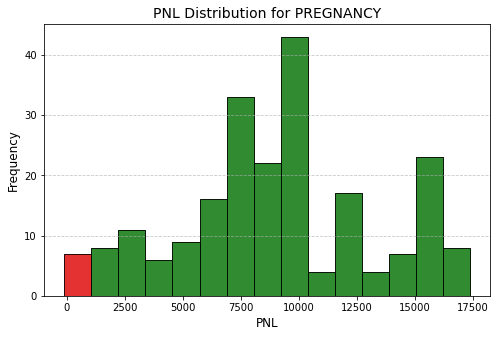

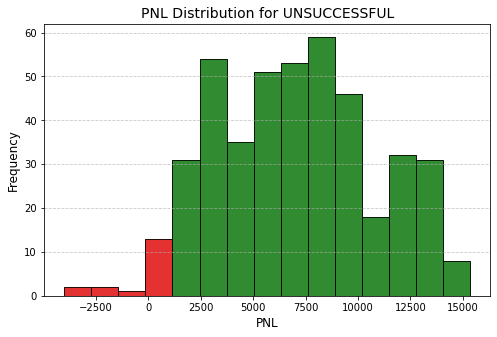

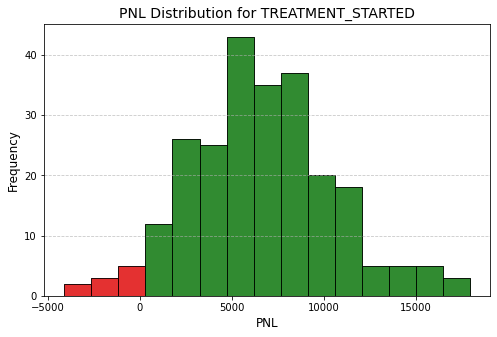

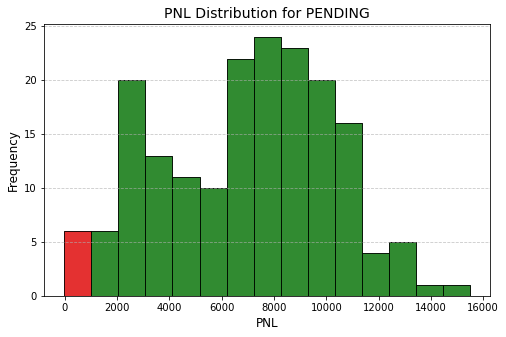

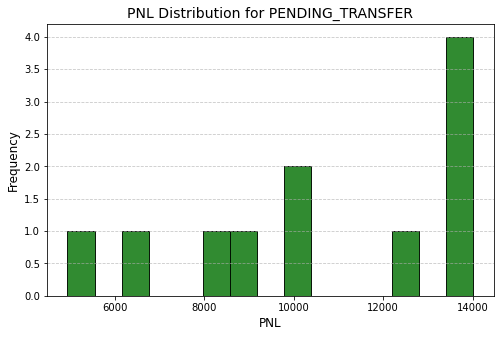

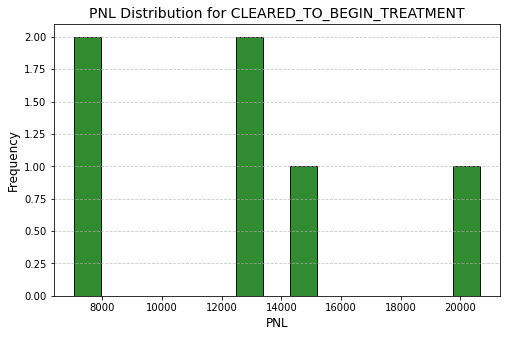

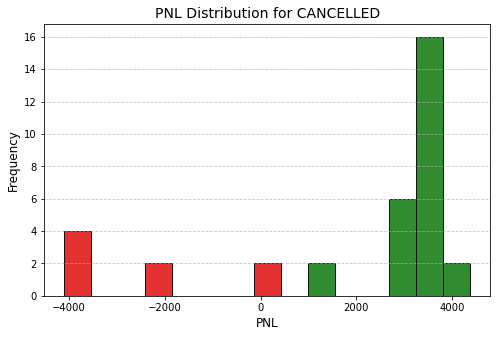

In [59]:
# Calculate the PNL for Gaia considering revenue and cost

# Calculate the PNL for Gaia
merged_data = merged_data.copy()
merged_data['pnl'] = merged_data['cycle_liability_post_discount'] - merged_data['gross_total_amount']

# Summary of PNL for each round_current_status
pnl_summary = merged_data.groupby('round_current_status')['pnl'].agg(['mean', 'sum', 'min', 'max'])
pnl_summary['sum'] = pnl_summary['sum'].apply(lambda x: f"{x:,.2f}")

print("\nPNL Summary for All Round Current Status:")
display(pnl_summary)

# Identify members who made Gaia lose money
loss_making_members = merged_data[merged_data['pnl'] < 0]

print("\nMembers Who Made Gaia Lose Money:")
display(loss_making_members[['membership_id', 'cycle_liability_post_discount', 'gross_total_amount', 'pnl']])

# Bar plots of PNL distribution for each round_current_status
import matplotlib.pyplot as plt

unique_statuses = merged_data['round_current_status'].unique()
for status in unique_statuses:
    status_data = merged_data[merged_data['round_current_status'] == status]['pnl']
    plt.figure(figsize=(8, 5))
    plt.hist(status_data, bins=15, edgecolor='black', alpha=0.7, color='gray')
    plt.title(f"PNL Distribution for {status}", fontsize=14)
    plt.xlabel("PNL", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Overlay bar coloring for positive and negative bins
    n, bins, patches = plt.hist(status_data, bins=15, edgecolor='black', alpha=0.7)
    for i in range(len(patches)):
        if bins[i] < 0:
            patches[i].set_facecolor('red')
        else:
            patches[i].set_facecolor('green')
    plt.show()
